In [1]:
import argparse
import logging
import time
from random import random
from PIL import Image, ImageFilter
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
os.chdir('../src/image-segmentation')
from graph import build_graph, segment_graph

In [2]:
def diff(img, x1, y1, x2, y2):
    _out = np.sum((img[x1, y1] - img[x2, y2]) ** 2)
    return np.sqrt(_out)


def threshold(size, const):
    return (const * 1.0 / size)


def generate_image(forest, width, height):
    random_color = lambda: (int(random()*255), int(random()*255), int(random()*255))
    colors = [random_color() for i in range(width*height)]

    img = Image.new('RGB', (width, height))
    im = img.load()
    for y in range(height):
        for x in range(width):
            comp = forest.find(y * width + x)
            im[x, y] = colors[comp]

    return img.transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)


def get_yellow_mask(image_array):
    lower_yellow = np.array([20, 150, 150])
    upper_yellow = np.array([50, 255, 255])

    # Convert image to HSV
    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)

    # Create a mask for yellow regions
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    return yellow_mask


def get_segmented_image(sigma, neighbor, K, min_comp_size, input_file, output_file):
    if neighbor != 4 and neighbor != 8:
        print('Invalid neighborhood chosen. The acceptable values are 4 or 8.')
        print('Segmenting with 4-neighborhood...')
    start_time = time.time()
    image_file = Image.open(input_file)

    size = image_file.size  # (width, height) in Pillow/PIL
    print('Image info: {} | {} | {}'.format(image_file.format, size, image_file.mode))

    # Convert the image to a numpy array
    image_array = np.array(image_file)

    # Apply yellow mask to the input image
    yellow_mask = get_yellow_mask(image_array)
    image_array[yellow_mask == 0] = [0, 0, 0]  # Set non-yellow regions to black
    plt.imshow(image_array)
    plt.show()

    # Gaussian Filter
    smooth = Image.fromarray(image_array).filter(ImageFilter.GaussianBlur(sigma))
    smooth = np.array(smooth).astype(int)

    print("Creating graph...")
    graph_edges = build_graph(smooth, size[1], size[0], diff, neighbor == 8)

    print("Merging graph...")
    forest = segment_graph(graph_edges, size[0] * size[1], K, min_comp_size, threshold)

    print("Visualizing segmentation and saving into: {}".format(output_file))
    image = generate_image(forest, size[1], size[0])
    image.save(output_file)
    # display with plt
    plt.imshow(image)
    plt.show()

    print('Number of components: {}'.format(forest.num_sets))
    print('Total running time: {:0.4}s'.format(time.time() - start_time))

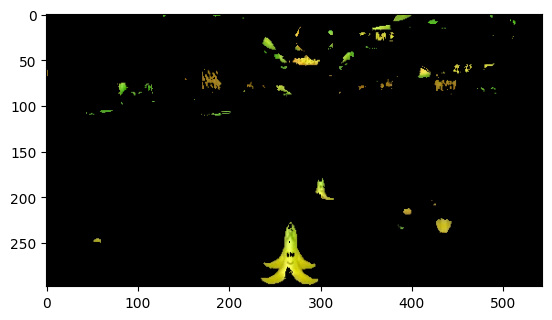

In [4]:
def get_yellow_mask(image_array):
    lower_yellow = np.array([20, 150, 150])
    upper_yellow = np.array([50, 255, 255])

    # Convert image to HSV
    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)

    # Create a mask for yellow regions
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    return yellow_mask

# Test the mask
def test_mask(input_file):
    image_file = Image.open(input_file)
    image_array = np.array(image_file)
    yellow_mask = get_yellow_mask(image_array)
    image_array[yellow_mask == 0] = [0, 0, 0]  # Set non-yellow regions to black
    plt.imshow(image_array)
    plt.show()

input_file = '../../img/banana_vehicule.JPG'
test_mask(input_file)

Image info: JPEG | (543, 298) | RGB


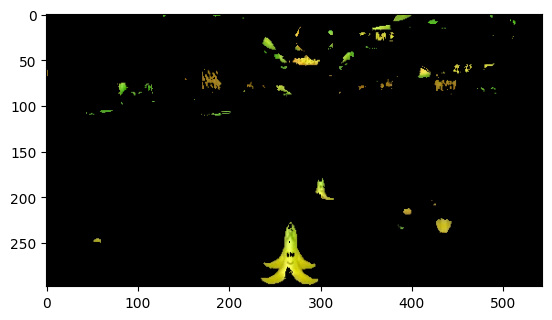

Creating graph...
Merging graph...
Visualizing segmentation and saving into: ../../img/banana_vehicule_out.JPG


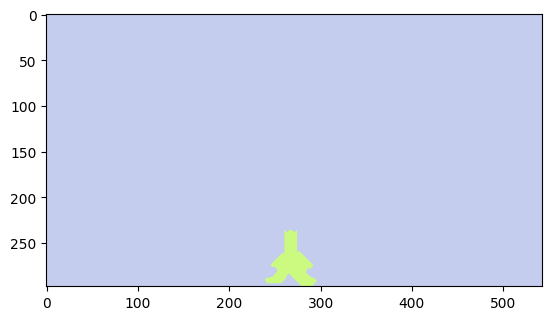

Number of components: 2
Total running time: 14.8s


In [6]:
sigma = 3
neighbor = 8
K = 10.0
min_comp_size = 500
input_file = '../../img/banana_vehicule.JPG'
output_file = '../../img/banana_vehicule_out.JPG'
get_segmented_image(sigma, neighbor, K, min_comp_size, input_file, output_file)
